This script is used to produce Figure 7 and Figure S5 - the relative importance of limitation terms and predictability of those limitation terms for a single initialization month (in this case, May) for a single year (in this case, 2010) for the Payne et al. paper "Quantifying the potential predictability of Arctic primary production". In order to reproduce these figure, the script will need to be run both for 2010 and 2030 data and for all variables of interest (e.g., 'diat_light_lim_Cweight_avg_100m', 'diat_N_lim_Cweight_avg_100m', and 'SST'). This involves running steps 2-7 many times.

1. Import packages

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors as c
import numpy as np
from scipy import interpolate
import scipy
from  matplotlib.cm import ScalarMappable
import glob
import xarray as xr
import math

2. Set the variable of interest and the year. Also read in the variable 'clim1' - this can be output from any scripts where the clim variable is created for NPP, and just provides a monthly climatology of NPP for each grid cell.

In [27]:
# a. Set the variable (vnam) and the year.
vnam = 'diat_light_lim_Cweight_avg_100m'#'SST' #'diat_light_lim_Cweight_avg_100m' #'diat_N_lim_Cweight_avg_100m'
NPP = False
yr = '2010'#'2030'

# b.Set directory information.
clim1 = xr.open_dataset("/glade/u/home/cpayne/PredictPerfect/CESM2_clims/NPP_clim.nc")
vdir = 'ocn'
vfil = '.pop.h.'+ vnam + '.'
vn = 1

3. Read in NPP files for diatom, diazotroph, and small phytoplankton functional types (photoC_diat_zint, photoC_diaz_zint, and photoC_sp_zint, respectively) from the CESM2-LE for years 2010-2015. NPP is calculated for each model grid cell and across all ensemble members for the years 2010-2012 (dat_climt). To switch between 2010 and 2030, change the file name and adjust dat[t,:,:]. Write out the climatology variable you've generated as a netcdf, then read it in later.

In [19]:
# a. Select variable of interest and locate the files
dat_clim = np.full([50, 36, 384, 320], np.nan)
for j in np.arange(0,vn):
    if NPP == True:
        fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/month_1/' + vnam[j] + '/'
    else:
        fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/month_1/' + vnam + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1

# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*201001*"): #### Change between '*201001*' and '*203001*'
        i = i + 1

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        if NPP == True:
            dat = ncfile[vnam[j]].values
        else:
            dat = ncfile[vnam].values
        lon, lat = ncfile.TLONG.values, ncfile.TLAT.values #if in 'ice', use 'TLON', in 'ocn', use 'TLONG'

# e. Interpolate lat and lon values over holes in the arrays
        ok = ~np.isnan(lon)
        xp = ok.ravel().nonzero()[0]
        fp = lon[~np.isnan(lon)]
        x  = np.isnan(lon).ravel().nonzero()[0]
        lon[np.isnan(lon)] = np.interp(x, xp, fp)

        ok = ~np.isnan(lat)
        xp = ok.ravel().nonzero()[0]
        fp = lat[~np.isnan(lat)]
        x  = np.isnan(lat).ravel().nonzero()[0]
        lat[np.isnan(lat)] = np.interp(x, xp, fp)

# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,36): 
                dat_clim[i,t,:,:] = dat[t,:,:]
                #### In 2010, this should read dat[t,:,:]. In 2030, it reads dat[t+60,:,:] to skip 2025-2029
        else:
            for t in range(0,36):
                dat_clim[i,t,:,:] = dat[t,:,:] + dat_clim[i,t,:,:]
                #### In 2010, this should read dat[t,:,:]. In 2030, it reads dat[t+60,:,:] to skip 2025-2029

# g. Sum over EMs, then divide by 50 to get a climatology for each grid cell
dat_climt = np.full([150, 384, 320], np.nan)
clim = np.full([12, 384, 320], np.nan)
clim_sd = np.full([12, 384, 320], np.nan)
clim_var = np.full([12, 384, 320], np.nan)

for t in range(0,12):
    dat_climt[0:50,:,:] = dat_clim[:,t,:,:]
    dat_climt[50:100,:,:] = dat_clim[:,t + 12,:,:]
    dat_climt[100:150,:,:] = dat_clim[:,t + 24,:,:]
    clim[t,:,:] = (np.sum(dat_climt, axis = 0)) / 150
    clim_sd[t,:,:] = np.std(dat_climt, axis = 0)
    clim_var[t,:,:] = np.var(dat_climt, axis = 0)


In [ ]:
#h. Write out the variable climatology. 
cdir = "/glade/u/home/cpayne/PredictPerfect/CESM2_clims/" + vnam + "_clim" + yr + ".nc"
ds = xr.Dataset(
    data_vars=dict(
        clim=(["time", "lat", "lon"], clim),
        clim_sd=(["time", "lat", "lon"], clim_sd),
        clim_var=(["time", "lat", "lon"], clim_var),
    ),
    coords=dict(
        TLON=(["lat", "lon"], lon),
        TLAT=(["lat", "lon"], lat),
        time=ncfile.time.values[0:12]
    ),
)
ds.to_netcdf(path = cdir, mode = 'w')

4. Calculate the area of each grid cell in the Arctic (here, >50°N). This variable is used to scale NPP by area and also to exclude sub-Arctic grid cells.

In [12]:
# a. Read in the areacello file and use this to weight each variable by the area of the grid cell.
acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
areacello_ocn = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(dat_climt[0,5,i,j]) == False and lat[i,j] > 50:
            areacello_ocn[i,j] = areacello[i,j]
    

5. Read in monthly NPP for the two-year perfect model experiments. These experiments were initialized every other month (6x per year) from five different CESM2-LE ensemble members and have 15 ensemble members in each set. Consequently, the dimensions of pmeall are initialization, initial ensemble member, ensemble member, time, longitude, latitude. *CRITICAL*: If the primary variable is SST, un-comment the lines in section 5a - the perfect model experiments only have temp output. This step will take a long time for the temp variable because it's 4D.

In [4]:
# a. Initialize arrays
# vnam = 'TEMP'
# vfil = '.pop.h.' + vnam + '.'
pmeall = np.full([6,5,15,24,384,320], np.nan)
pme_var = np.full([6,5,24,384,320], np.nan)
pme_mean = np.full([6,5,24,384,320], np.nan)

imstr = ('01', '03', '05', '07', '09', '11')

# b. Set up big loop for opening arrays and calculating variance
for imno in np.arange(0,6):
    im = imstr[imno]
    print(im)
    stmon = '2010' + im
    for i in np.arange(0,6,1):
        if im == imstr[0]:
            enmon = '201112'
        elif im == imstr[i]:
            enmon = '2012' + str(i*2).zfill(2)
    i = -1
    for init in np.arange(0,5):
        if init == 0:
            l = ''
        else:
            i = i + 1
            let = ['b', 'c', 'd', 'e']
            l = let[i]

# c. Loop through the ensemble members. Open the appropriate file and add it to the array
        for ens in np.arange(0,15):
            i1 = ens + 1 
            ### To switch between 2010 and 2030, change the first part of pmedir to either
            #/glade/campaign/cgd/ppc/mholland/predict_cesm2/b.e21.BHIST_CESM2_2010_      or
            #/glade/campaign/cgd/ppc/mholland/predict_cesm2_2030/b.e21.BSSP370smbb_CESM2_2030_
            pmedir = '/glade/campaign/cgd/ppc/mholland/predict_cesm2/b.e21.BHIST_CESM2_2010_' + im + '_ens00'+ str(i1) + str(l) +'/' + vdir + '/proc/tseries/month_1/'
            ### To switch between 2010 and 2030, change the first part of the file name (following pmedir) to
            # 'b.e21.BHIST_CESM2_2010_' or 'b.e21.BSSP370smbb_CESM2_2030_'.
            pmef = pmedir + 'b.e21.BHIST_CESM2_2010_' + im + '_ens00' + str(i1) + str(l) + vfil + stmon + '-' + enmon + '.nc'
            pme = xr.open_dataset(pmef)
            pmeall[imno,init,ens,:,:,:] = pme[vnam][:,:,:]
            vname = vnam

# d. Calculate variability across the perfect model ensemble members
pme_var[:,:,:,:,:] = np.var(pmeall[:,:,:,:,:,:], axis = 2)
pme_mean[:,:,:,:,:] = np.nanmean(pmeall[:,:,:,:,:,:], axis = 2)


01
03
05
07
09
11


/glade/derecho/scratch/cpayne/tmp/ipykernel_47746/4245035676.py:49: RuntimeWarning: Mean of empty slice
  pme_mean[:,:,:,:,:] = np.nanmean(pmeall[:,:,:,:,:,:], axis = 2)


6. For the SST/TEMP variable only - we have to convert temperature to the limitation on phytoplankton growth by temperature. Run this section of the script to do so.

In [ ]:
# a. Modify pmeall and dat_climt by the reference temperature to calculate the temperature limitation terms for phytoplankton.
Tref = 30; q10 = 2.0;
#calculate tfunc
pmeall = q10**((pmeall - Tref) / 10.)
dat_climt = q10**((dat_climt - Tref) / 10.)


7. Calculate PPP across the Arctic for the two years of each initialization. Variance for the perfect model experiments is calculated as a mean across the five different ensemble members the forecast simulations were initialized from.

In [28]:
# Calculate PPP for the whole Arctic - logged values
# a. initialize empty arrays
PPP_arc = np.zeros([6,24])
totarc_sumclim = np.zeros([150,12]); totarc_sumpme = np.zeros([6,5,15,24]);
totarc_varclim = np.zeros([12]); totarc_varpme = np.zeros([6,24]);

# b. Loop through grid cells. In the Arctic, add climatological NPP by month (taking grid cell area into
#    account). Then find the mean and variance for the log(NPP).
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            for t in np.arange(0,12):
                totarc_sumclim[:,t] = dat_climt[:,t, i, j]*areacello_ocn[i,j] + totarc_sumclim[:,t]
totarc_varclim[:] = np.var(totarc_sumclim[:,:], axis = 0)

# c. Loop through initialization months (6) of perfect model experiments as well as grid cells. 
#    In the Arctic, add climatological NPP by month (taking grid cell area into account). Then find 
#    the mean and variance for the log(NPP) for each initialization month.
for imno in np.arange(0,6):
    for i in np.arange(0,384):
        for j in np.arange(0,320):
            if np.isnan(areacello_ocn[i,j]) == False:
                for t in np.arange(0,24):
                    totarc_sumpme[imno,:,:,t] = pmeall[imno,:,:,t,i,j]*areacello_ocn[i,j] + totarc_sumpme[imno,:,:,t]
    totarc_varpme[imno,:] = np.nanmean(np.var(totarc_sumpme[imno,:,:,:], axis = 1), axis = 0)

# d. Calculate the PPP for each initialization (6) and each month (24). Log variance is calculated using 
#    equations from Campbell (1995). Note that the variance of the climatology is calculated using the 
#    correct month (t is the forecast month, so tclim is calculated to find the actual month).
for imno in np.arange(0,6):
    for t in np.arange(0,24):
        tclim = t + imno * 2
        if tclim >= 12:
            tclim = tclim - 12
        if tclim >= 12:
            tclim = tclim - 12
        PPP_arc[imno,t] = 1 - (totarc_varpme[imno,t] / totarc_varclim[tclim])
 

In [ ]:
# e. Set PPP_arc to be equal to a descriptive variable - e.g. Llim - to allow it to be plotted 
#    with other variables.
Llim = PPP_arc

8. Calculate clim_arc using the climatological NPP. This will be used to calculate the background gradient.

In [20]:
clim_arc = np.zeros(12); climmax = 0
for t in np.arange(0,12,1):
    clim_arc[t] = np.nansum(clim1["clim"][t,:,:] * areacello_ocn) / np.nansum(areacello_ocn)
    if clim_arc[t] > climmax:
        climmax = clim_arc[t]

9. To generate Figure 7b and S5b: Run through steps 2-7 for SST, light, and N limitation terms until you've calculated Llim2010, Nlim2010, and Tlim2010 variables (for example). Choose the initialization month desired (e.g. imno = 2) and adjust the array 'monnam' to have the correct month names for the initialization.

(0.0, 1.0)

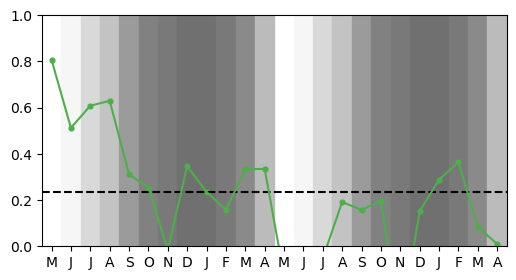

In [26]:
# a. Select the desired initialization month (0 = January, 1 = March, etc.) and adjust monnam values 
#    to get the correct months on the x axis.
imno = 2
monnam = ['M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 
          'N', 'D', 'J', 'F', 'M', 'A']

# b. Set up the background gradient colors and the colorbar for that gradient.
bgcols = ['#FFFFFF', '#F9F9F9', '#F6F6F6', '#F1F1F1', '#ECECEC', '#E6E6E6', '#E0E0E0', '#D9D9D9', '#D2D2D2',
          '#CACACB', '#C3C3C3', '#BBBBBB', '#B3B3B3', '#ABABAB', '#A3A3A3', '#9B9B9B', '#929292', '#8A8A8A',
          '#818181', '#797979', '#707070']
vals = np.arange(0,1.1,1)
cols = ['#707070','#FFFFFF']
norm = plt.Normalize(vals[0], vals[-1])
cmap = c.LinearSegmentedColormap.from_list('', list(zip(np.array(vals)/vals[-1], cols)))

# c. Initialize the figure and prepare the background gradient. Also set the significance line.
fig = plt.figure(figsize=(6,3)) 
ax = fig.subplots()
for t in np.arange(0,12):
    treal = t + imno*2
    if treal > 11:
        treal = treal - 12
    bgval = int(20 - np.round(clim_arc[treal]/climmax*20, 0))
    ax.axvspan(t - .5, t + .5, color=bgcols[bgval]);
    ax.axvspan(t + 11.5, t + 12.5, color=bgcols[bgval]);
    ax.axvspan(t + 23.5, t + 24.5, color=bgcols[bgval]);
plt.axhline(y=0.23446493, color = 'black', linestyle = 'dashed')

# d. Plot PPP for the chosen initialization and for all of the desired limitation terms.
lim_init = np.zeros(24)
for t in np.arange(0,24):
    tclim = t 
    if tclim >= 12:
        tclim = tclim - 12
plt.plot(np.arange(0,24), Nlim[imno,:], color = '#4daf4a'); 
plt.scatter(np.arange(0,24), Nlim[imno,:], s= 12, color = '#4daf4a')
plt.plot(np.arange(0,24), Llim[imno,:], color = '#dede00'); 
plt.scatter(np.arange(0,24), Llim[imno,:], s= 12, color = '#dede00')
plt.plot(np.arange(0,24), Tlim[imno,:], color = '#e41a1c'); 
plt.scatter(np.arange(0,24), Tlim[imno,:], s= 12, color = '#e41a1c')

plt.xticks(np.arange(0,24), monnam); plt.xlim(-.5,23.5)
plt.ylim(0,1)
# plt.xlabel('Month'), plt.ylabel('PPP'); 

# e. Write out plot.
# figdir = '/glade/u/home/cpayne/PredictPerfect/Figures/PaperFigs/PPP_lightntemp_052030.png';
# plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()

10. Read in netcdf files generated as part of step 3. These are used to calculate relative limitation terms for N, light, and temperature (relying on eq. 2 presented in the manuscript).

In [ ]:
climl = xr.open_dataset("/glade/u/home/cpayne/PredictPerfect/CESM2_clims/diat_light_lim_Cweight_avg_100m_clim_2010.nc")
climn = xr.open_dataset("/glade/u/home/cpayne/PredictPerfect/CESM2_clims/diat_N_lim_Cweight_avg_100m_clim_2010.nc")
climta = xr.open_dataset("/glade/u/home/cpayne/PredictPerfect/CESM2_clims/SST_clim_2010.nc")

Tref = 30; q10 = 2.0; PCref_diat = 4.8
#calculate tfunc
climt = np.zeros([12,384,320])
climt[:,:,:] = q10**((climta['clim'][:,:,:] - Tref) / 10.)

tlim, llim, nlim, maxlim = np.zeros([12,384,320]), np.zeros([12,384,320]), np.zeros([12,384,320]), np.zeros([12,384,320])
for i in np.arange(0,384):
    if i > 300 and i%10 == 0:
        print(i)
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            for t in np.arange(0,12):
                tlim[t,i,j] = (1 - climt[t,i,j]) / ((1 - climt[t,i,j]) + (1 - climn['clim'][t,i,j]) + (1 - climl['clim'][t,i,j]))
                llim[t,i,j] = (1 - climl['clim'][t,i,j]) / ((1 - climt[t,i,j]) + (1 - climn['clim'][t,i,j]) + (1 - climl['clim'][t,i,j]))
                nlim[t,i,j] = (1 - climn['clim'][t,i,j]) / ((1 - climt[t,i,j]) + (1 - climn['clim'][t,i,j]) + (1 - climl['clim'][t,i,j]))


310
320
330
340
350
360


11. Plot Figure 7a / S5a - the relative importance of the different limitation terms during a given initialization month, plotted against a background gradient.

In [ ]:
# a. Select the desired initialization month (0 = January, 1 = March, etc.) and adjust monnam values 
#    to get the correct months on the x axis.
imno = 2
monnam = ['M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 
          'N', 'D', 'J', 'F', 'M', 'A']

# b. Set up the background gradient colors and the colorbar for that gradient.
bgcols = ['#FFFFFF', '#F9F9F9', '#F6F6F6', '#F1F1F1', '#ECECEC', '#E6E6E6', '#E0E0E0', '#D9D9D9', '#D2D2D2',
          '#CACACB', '#C3C3C3', '#BBBBBB', '#B3B3B3', '#ABABAB', '#A3A3A3', '#9B9B9B', '#929292', '#8A8A8A',
          '#818181', '#797979', '#707070']

# c. Initialize the figure and prepare the background gradient. Also set the significance line. This
#    involves calculating treal, which uses desired initialization month to go back and calculate the
#    correct time to identify in the climatology.
l_lim_im = np.zeros(24); t_lim_im = np.zeros(24); n_lim_im = np.zeros(24); 
fig = plt.figure(figsize=(6,3))
ax = fig.subplots()
for t in np.arange(0,12):
    treal = t + imno*2
    if treal > 11:
        treal = treal - 12
    l_lim_im[t] = llim[treal]; n_lim_im[t] = nlim[treal]; t_lim_im[t] = tlim[treal]; 
    l_lim_im[t+12] = llim[treal]; n_lim_im[t+12] = nlim[treal]; t_lim_im[t+12] = tlim[treal]; 
    bgval = int(20 - np.round(clim_arc[treal]/climmax*20, 0))
    ax.axvspan(t - .5, t + .5, color=bgcols[bgval]);
    ax.axvspan(t + 11.5, t + 12.5, color=bgcols[bgval]);
    ax.axvspan(t + 23.5, t + 24.5, color=bgcols[bgval]);

# d. Plot the relative limitation terms for light, N, and temperature.
plt.plot(np.arange(0,24), l_lim_im, color = '#dede00')
plt.plot(np.arange(0,24), t_lim_im, color = '#e41a1c')
plt.plot(np.arange(0,24), n_lim_im, color = '#4daf4a')
plt.ylim(0,0.53); plt.xlim(-.5,23.5); plt.xticks(np.arange(0,24), monnam)

# e. Write the figure out.
# figdir = '/glade/u/home/cpayne/PredictPerfect/Figures/PaperFigs/lims_052030.png';
# plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()

12. Calculate the relative PPP, or the relative importance of each limitation term in controlling the predictability of NPP (equation 3 in manuscript). Then plot this, forming Figure 7c and S5c.

In [ ]:
# a. Calculate the relative PPP of the different limitation terms.
llim_init = np.full([6,34], np.nan); tlim_init = np.full([6,34], np.nan); nlim_init = np.full([6,34], np.nan); 
for imno in np.arange(0,6):
    for t in np.arange(0,24):
        treal = t + imno * 2
        tclim = treal
        if tclim >= 12:
            tclim = tclim - 12
        if tclim >= 12:
            tclim = tclim - 12
        llim_init[imno,treal] = Llim[imno,t] * llim[tclim]
        tlim_init[imno,treal] = Tlim[imno,t] * tlim[tclim]
        nlim_init[imno,treal] = Nlim[imno,t] * nlim[tclim]


In [ ]:
# b. Select the desired initialization month (0 = January, 1 = March, etc.) and adjust monnam values 
#    to get the correct months on the x axis.
imno = 2
monnam = ['M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 
          'N', 'D', 'J', 'F', 'M', 'A']

# c. Initialize the figure.
lim_val = np.zeros([6,34])
fig = plt.figure(figsize=(6,3)) ;ax = fig.subplots()

# d. Plot relative PPP for the chosen initialization month. Do this by getting rid of sub-zero values
#    and calculate the sum of all limitation terms (this is divided out)
for treal in np.arange(0,34):
    if llim_init[imno,treal] < 0:
        llim_init[imno,treal] = 0
    if nlim_init[imno,treal] < 0:
        nlim_init[imno,treal] = 0
    if tlim_init[imno,treal] < 0:
        tlim_init[imno,treal] = 0
    lim_val[imno,treal] = tlim_init[imno,treal] + llim_init[imno,treal] + nlim_init[imno,treal]

# e. Plot relative PPP
    plt.fill_between(np.arange(0,34), tlim_init[init,:]/lim_val[init,:], color = '#e41a1c')
    plt.fill_between(np.arange(0,34), tlim_init[init,:]/lim_val[init,:], tlim_init[init,:]/lim_val[init,:] + llim_init[init,:]/lim_val[init,:], color = '#dede00')
    plt.fill_between(np.arange(0,34), tlim_init[init,:]/lim_val[init,:] + llim_init[init,:]/lim_val[init,:], 1, color = '#4daf4a')
    plt.xticks(np.arange(4,28), monnam); plt.ylim(0,1);
    plt.xlim(3.5,27.5); # Adjust xlim to reflect the initialization month

# f. Plot lines around the most productive months (dependent on initialization month).
plt.axvline(x=6.5, color = 'black', linestyle = 'dashed');
plt.axvline(x=15.5, color = 'black', linestyle = 'dashed');
plt.axvline(x=18.5, color = 'black', linestyle = 'dashed');
#plt.axvline(x=27.5, color = 'black', linestyle = 'dashed');

# g. Write out plot.
# figdir = '/glade/u/home/cpayne/PredictPerfect/Figures/PaperFigs/ppplims_052030.png';
# plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()